In [68]:
from orphics import io, maps, lensing, cosmology, stats
from pixell import enmap, curvedsky
import numpy as np
import os, sys
import healpy as hp
import matplotlib.pylab as plt
import symlens as s
from symlens import utils
import importlib
from mpi4py import MPI
import pandas as pd
import tools

In [87]:
# Simulate bias of lensing reconstruction from non-Gaussian kSZ

# map source, 'Colin' or 'websky'
map_source = 'Colin'
# 'lt' for late-time kSZ or 'ri' for reionization kSZ
ksz_type = 'lt'

# experiment configuration, name:[nlev_t,beam_arcmin]
# experiments={'reference':[0,0]}
experiments={'CMB_S4':[1,3]}
#experiments = {'Planck_SMICA':[45,5], 'CMB_S3':[7,1.4], 'CMB_S4':[1,3]}

# Use maps provided by websky
map_path = 'maps/' + map_source + '/'
# Path of output data
data_path = 'data/'

# lmin, lmax for cmb maps
ellmin = 100
ellmaxs = [4000]
# ellmaxs = [3000, 4000, 4500]
# bin width for reconstructed kappa powerspectrum
delta_L = 40

# pixel size in arcmin
px_arcmin = 1.

data_path = 'data/test/'
importlib.reload(tools)
ps = pd.read_csv('data/test/'+map_source+'_'+ksz_type+'_'+'CMB_S4_%s_4000.csv' %(ellmin))
experiment_names = [ name for name in experiments.keys()]
experiment_names[0]

'CMB_S4'

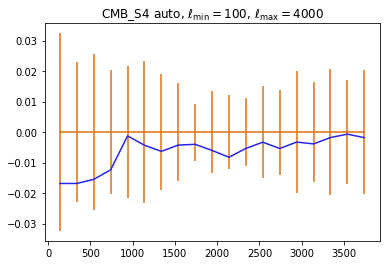

In [88]:
plt.plot(ps['Ls'], ps['bias'])
#plt.errorbar(ps['Ls'], ps['bias'], yerr=ps['bias_err'])
plt.errorbar(ps['Ls'], np.zeros(np.shape(ps['Ls'])), yerr=ps['bias_err'])
plt.title(r'%s auto, ${\ell}_{\mathrm{min}}=%s$, ${\ell}_{\mathrm{max}}=%s$' %(experiment_names[0],ellmin, ellmaxs[0]))
plt.savefig('data/test/'+map_source+'_'+ksz_type+'_'+experiment_names[0]+'_'+'%s_%s.png' %(ellmin, ellmaxs[0]))